In [1]:
import numpy as np
import pandas as pd
import pyodbc
import sqlalchemy
import sqlite3
from subprocess import check_output
import os
from IPython.core.display import Image, display

from sqlalchemy import create_engine
engine = create_engine('sqlite:////...', echo=False)

## 1. Query lifecycle and the planner
#### Basic query lifecycle.

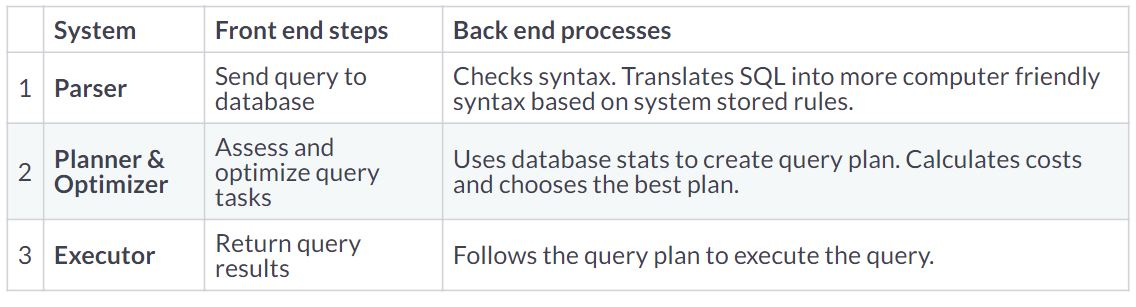

In [2]:
####

### `Query` planner & optimizer.
#### Responsive to `SQL structure changes`
- **`Generate plan trees`**:

$\qquad \quad \diamond$ `Nodes` corresponding to `steps`.

$\qquad \quad \diamond$ Visualize with `EXPLAIN`.

- **`Estimate cost` of each `tree`**:

$\qquad \quad \diamond$ Statistics from `pg_tables`

$\qquad \quad \diamond$ Time based optimization.

#### A. Statistics from `pg_tables`

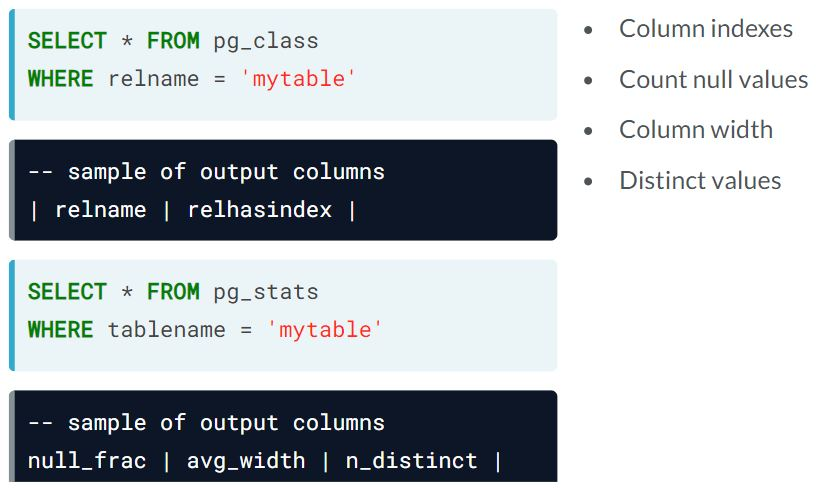

In [3]:
## illustration

#### B. The `EXPLAIN` command.

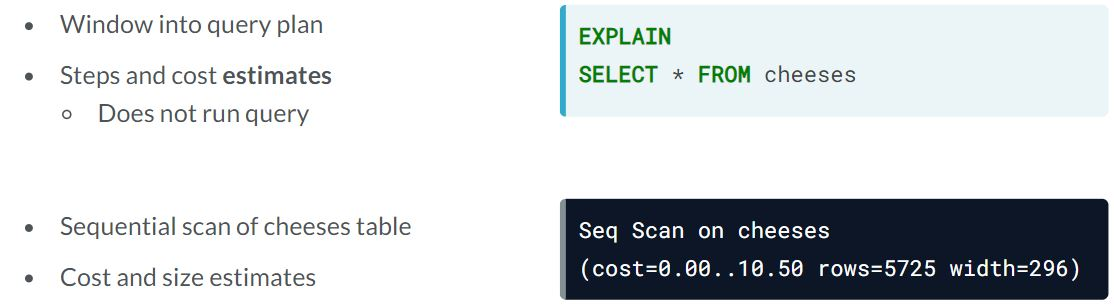

In [4]:
####

**`EXPLAIN`: Scan** or **`sequential scan`**

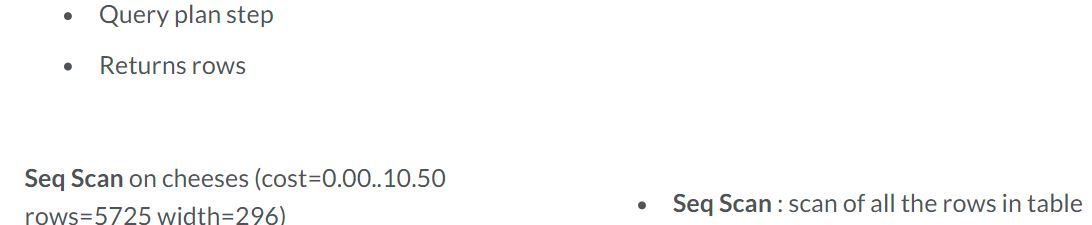

In [5]:
####

**`EXPLAIN`: Cost**

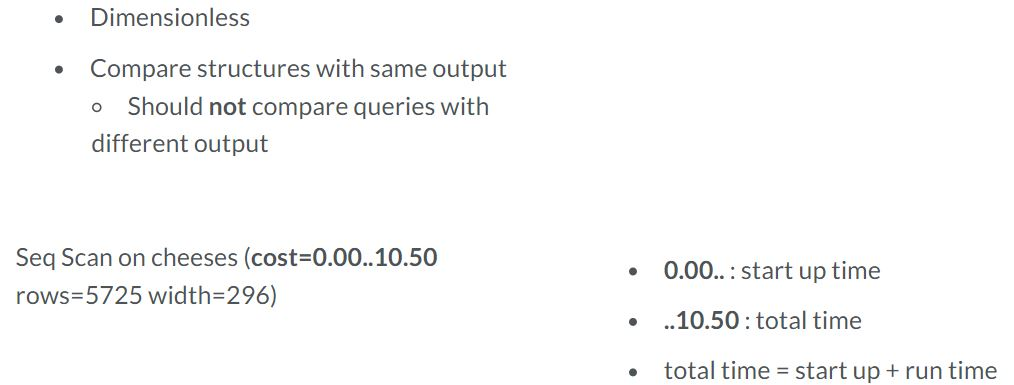

In [6]:
####

**`EXPLAIN`: Size**

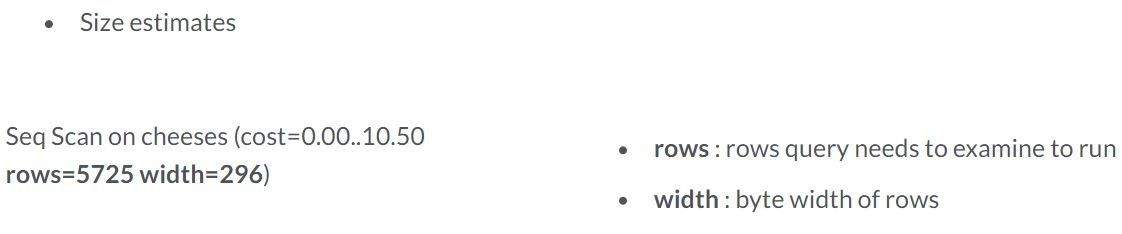

In [7]:
####

#### `Explain` with a `WHERE` clause.

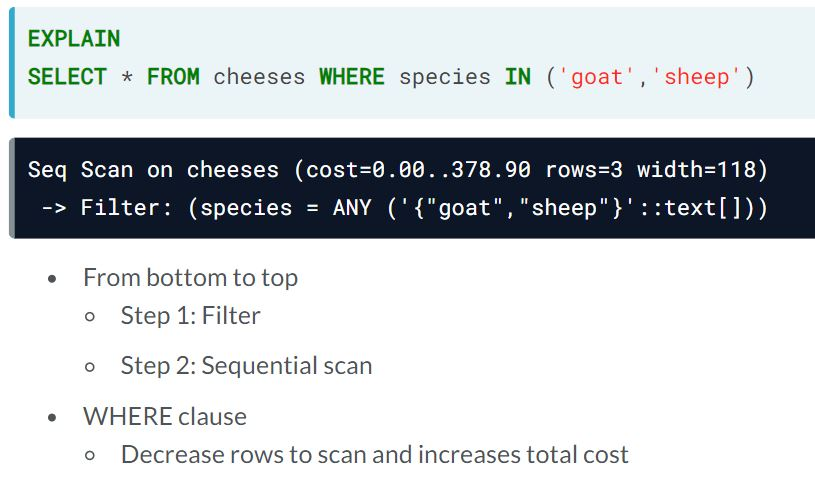

In [8]:
####

#### `EXPLAIN` with an `index`.

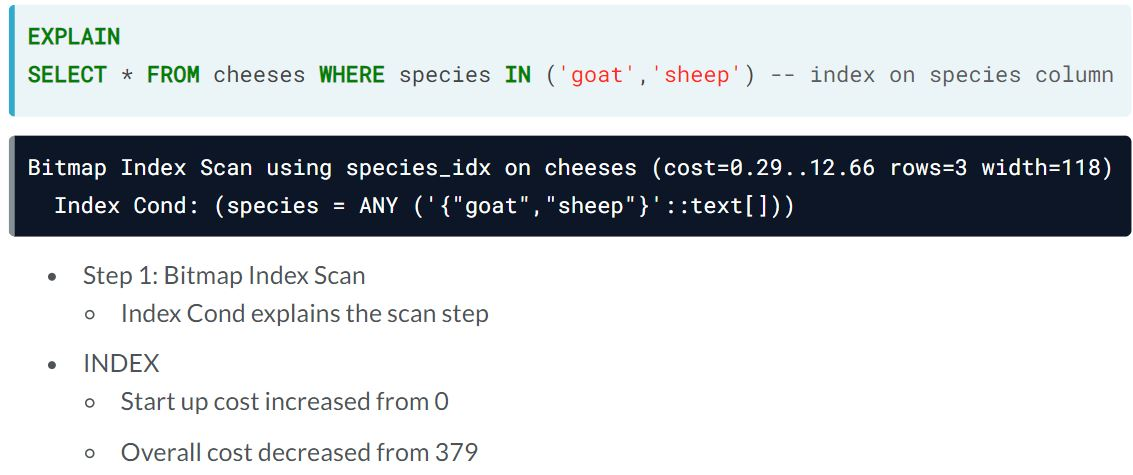

In [9]:
####

### EXERCISEs
#### Exercise 1.1. Exploring pg_tables
$\qquad$ In order to make a `query` plan, the `query planner` needs basic information like `table names`, `column names`, and the `number of rows` of each `table` or `view`. 

$\qquad$ Without this information, the `planner` would not know how many rows to search to find a specific columns used in `filter conditions`. It would not know if it can use an `index search`.

$\qquad$ This `type` of `metadata` is stored in the `pg_tables` `schema`. Specifically, the planner uses `pg_class` and `pg_stats`. Take a look to see what kind of information these objects contain.

#### Instructions.
**Step 1.** First, find all the columns in `pg_class`. Then select the column that indicates if the `daily_aqi` table has an index.

**SOLUTION.**

                    SELECT * -- Index indicator column
                    FROM pg_class
                    WHERE relname = 'daily_aqi';

- **`query result.`**

relname|relnamespace|reltype|reloftype|relowner|relam|relfilenode|reltablespace|relpages|reltuples|relallvisible|reltoastrelid|relhasindex|relisshared|relpersistence|relkind|relnatts|relchecks|relhasoids|relhasrules|relhastriggers|relhassubclass|relrowsecurity|relforcerowsecurity|relispopulated|relreplident|relispartition|relrewrite|relfrozenxid|relminmxid|relacl|reloptions|relpartbound
:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-
daily_aqi|2200|16452|0|16384|0|16450|0|381|31433|0|16453|true|false|p|r|11|0|false|false|false|false|false|false|true|d|false|0|578|1|null|null|null

**Step 2.** Use `pg_stats` to find column level statistics. Filter the `daily_aqi` table to category.

**SOLUTION.**

                    SELECT *
                    FROM pg_stats
                    WHERE tablename = 'daily_aqi'
                    AND attname = 'category';

- **`query result.`**

schemaname|tablename|attname|inherited|null_frac|avg_width|n_distinct|most_common_vals|most_common_freqs|histogram_bounds|correlation|most_common_elems|most_common_elem_freqs|elem_count_histogram
:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-|:-
public|daily_aqi|category|false|0|6|6|{Good,Moderate,"Unhealthy for Sensitive Groups",Unhealthy,"Very Unhealthy",Hazardous}|0.7057,0.253633,0.0314667,0.00833333,0.000666667,0.0002|null|0.448843|null|null|null

- **Comments.**

$\qquad \diamond$ `pg_class` provides table `level statistics` and `pg_stats` provides column level statistics that the `query planner` uses to make its plan and estimate the costs.

$\qquad \diamond$ Did you notice the `six distinct category values` are also the `six most common`?

#### Exercise 1.2. `Basic EXPLAIN`
$\qquad$ `Checking the query plan` is an `excellent window` into the `query function`. 

$\qquad$ Seeing the `query plan` steps helps you understand if you can `restructure` your `query` or `add additional conditions` to `limit the rows` and `improve query speed`. 

$\qquad$ `Comparing` the relative costs between `different query structures` helps you see `which plan is more efficient`.

$\qquad$ Here, you will be examining `USA daily air quality` data. First, familiarize yourself with running a `query` that will show the `query plan`.

#### Instructions.
- Write a `query` to choose all the columns and rows from the `daily_aqi` table.
- Add the `EXPLAIN` command to show the query plan.

**SOLUTION.**

                        EXPLAIN
                        SELECT * 
                        FROM daily_aqi;
- **`query result`.**

|`QUERY PLAN`|
|:-|
|`Seq Scan on daily_aqi  (cost=0.00..695.33 rows=31433 width=62)`|

- **Comments.** This `simple query` performed a `sequential scan` on the `31,433 rows` in the `daily_aqi` table.

#### Exercise 1.3. Index scans
$\qquad$ Your friend lives in `Hawaii` where the volcanic smog is aggravating his `asthma`. 

$\qquad$ You are helping him research new locations to live by using the `Environmental Protection Agency's county level air quality` data. You decide his **`new home should have good air quality at least 90% of the days`**.

$\qquad$ You know there are a lot of `counties in the USA`, and the `air quality` table is `large`. Your `first query` (not shown) did a `sequential scan` and took a long time to run.

$\qquad$ You decide to add an `index` to the `column` tracking the number of `good air quality days`. Examine the `query plan` and see the `type of scan`.

#### Instructions
- Create an `index` for the `annual_aqi` table using the `good` column.
- Only include results with `good air quality` at least `90% of the year`.
- Focus on `recent years` by limiting `aqi_year` to `2017` and `2018`.

**SOLUTION.**

                    CREATE INDEX good_index 
                    ON annual_aqi(good);

                    EXPLAIN
                    SELECT state_name, county_name, aqi_year, good
                    FROM annual_aqi
                    WHERE good > 327 -- 90% of the year
                    AND aqi_year IN (2017, 2018);

- **`query result`.**

| `QUERY PLAN` |
|`Bitmap Heap Scan on annual_aqi  (cost=26.17..155.82 rows=236 width=21)`|
|$\,$ ` Recheck Cond: (good > 327)`|
|$\;\,$ ` Filter: (aqi_year = ANY ('{2017,2018}'::integer[]))` |
|$\qquad$ ` ->  Bitmap Index Scan on good_index  (cost=0.00..26.11 rows=1310 width=0)` |
|$\qquad \,$  `      Index Cond: (good > 327) `|

- **Comments.** 

$\qquad \diamond$ The `index` changed the `query planner` to a `Bitmap Index Scan` first and then a `Bitmap Heap Scan`. 

$\qquad \diamond$ `Both of these` are ***more targeted scans*** than a `Sequential Scan`.

#### Exercise 1.4. `EXPLAIN` the `WHERE`
$\qquad$ Running a `query` with `EXPLAIN` does `not actually run the query`. Thus, `EXPLAIN` provides estimates of the `query plan`. 

$\qquad$ The `cost`, `rows`, and `width` are `all estimates`. `Some query structures result` in `better estimates` than `other structures`.

$\qquad$ You will take another look at `Hawaiian air quality`, focusing on the `days` where `multiple locations` `fell` into that `AQI category` (`good`, `moderate`, etc.). You will then look at the `impact of a partition` on the `query plans estimates`. **Does the `partition` change the `planner's estimates`**?

#### Instructions.
**Step 1.** Using a table of `daily AQI`, `count` the `days` in Hawaii with `more than one site` reporting that air quality category.

**SOLUTION.**

                    SELECT COUNT(*)
                    FROM daily_aqi
                    WHERE state_code = 15 -- Hawaii state code
                    AND no_sites > 1;
- **`query result`.**

| count |
|:-:|
| 694 |

**Step 2.** Examine the `query plan` `row` estimate using the same two `WHERE clause filters`. Is it the same as the `prior 694`?

**SOLUTION.**

                    EXPLAIN
                    SELECT *
                    FROM daily_aqi
                    WHERE state_code = 15 -- Hawaii state code
                    AND no_sites > 1;
- **`query result`.**

|`QUERY PLAN`|
|:-|
|`Seq Scan on daily_aqi  (cost=0.00..598.17 rows=24 width=182)`|
|$\;\,$ `Filter: ((no_sites > 1) AND (state_code = 15))`|


**Step 3.** Run the same `query` on `daily_aqi_partitioned`, a `partitioned table`. Is the `row estimate` the actual 694 row count?

**SOLUTION.**

                    EXPLAIN
                    SELECT *
                    FROM daily_aqi_partitioned
                    WHERE state_code = 15 -- partitioned on state code
                    AND no_sites > 1;
- **`query result`.**

|`QUERY PLAN`|
|:-|
|`Seq Scan on daily_aqi_partitioned  (cost=0.00..18.84 rows=1 width=182)`|
|$\;\,$ `  Filter: ((no_sites > 1) AND (state_code = 15))`|
- **Comments.**

$\qquad \diamond$ `EXPLAIN` shows the `query plan` steps and uses `estimates` for the `cost` and `size metrics`. The `first query` correctly counted `694 records in Hawaii`. 

$\qquad \diamond$ The `second query`, `without the partition`, estimated fewer than the 694 rows in the query plan. This final query, using a partition, correctly estimated `rows = 694` in the `query plan`.

## 2. A deeper dive into EXPLAIN
### `EXPLAIN` optional `parameters`

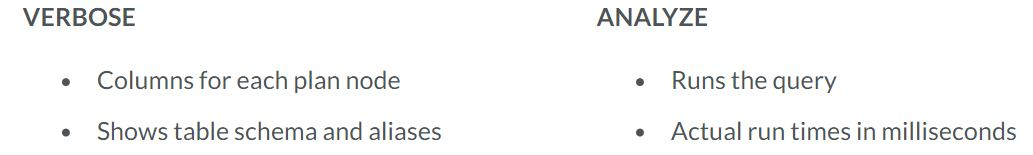

In [10]:
####

#### A. `VERBOSE`.

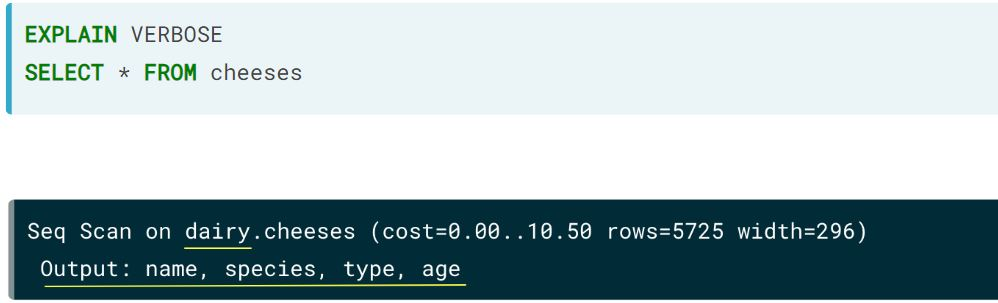

In [11]:
#### illustration

#### B. `ANALYZE`.

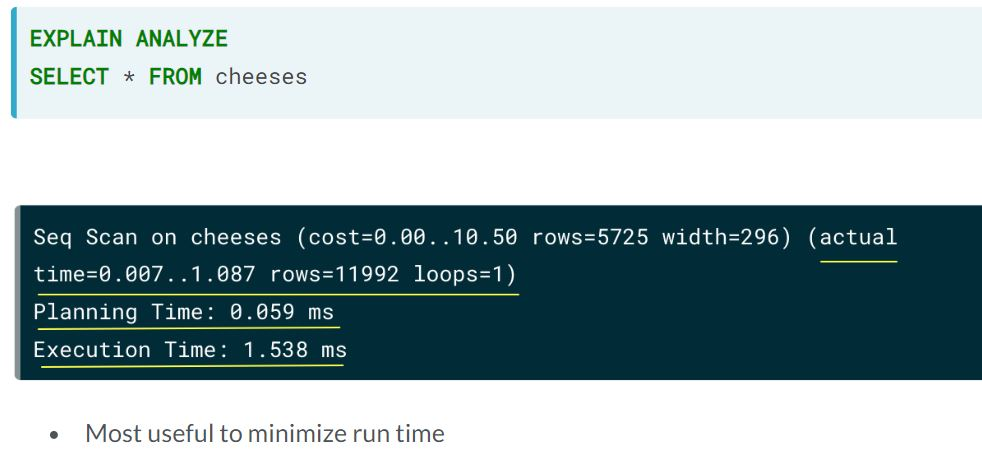

In [12]:
#### illustration

### `Query plan`-`aggregation.`

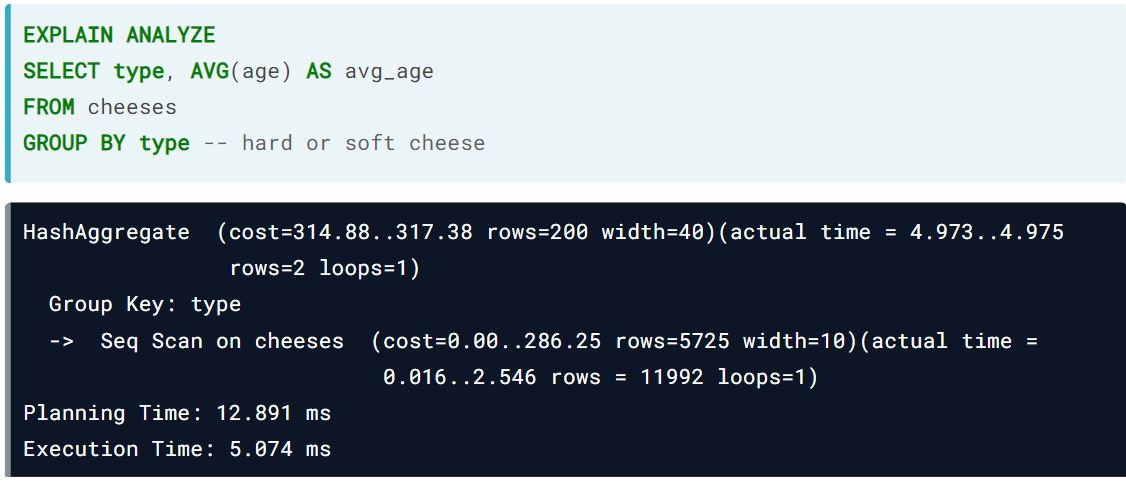

In [13]:
#### illustration

### `Query plan`-`sort`

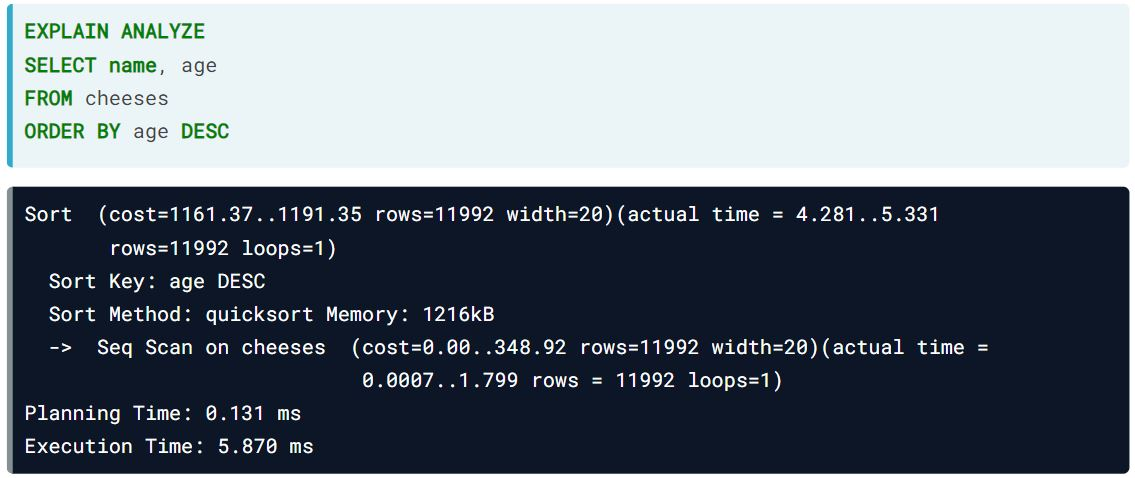

In [14]:
#### illustration

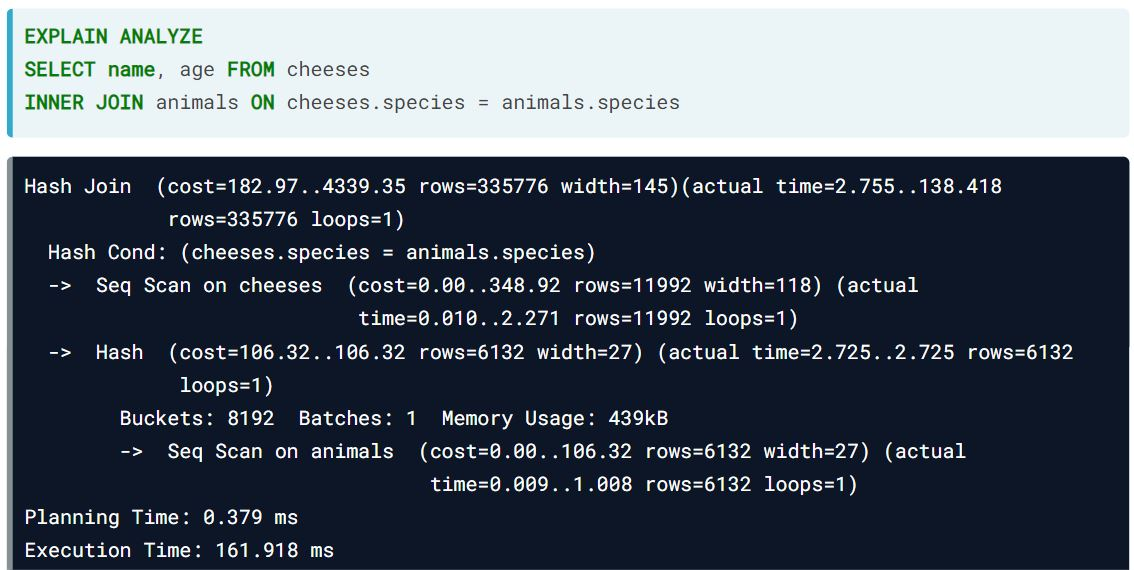

In [15]:
#### contiuned

### EXERCISEs.
#### Exercise 2.1. EXPLAIN parameters
- `EXPLAIN` gives a window into the `query plan`. It has some optional parameters that provide additional information. You want to try out these `optional parameters`, focusing on the `VERBOSE` and `ANALYZE parameters`.

- `VERBOSE` allows you to see the available columns at each step of the plan. `ANALYZE` computes actual run times in `milliseconds`. Which `parameter's output` do you find most useful?

#### Instructions
**Step 1.** Check out the `query plan` with the `VERBOSE` option so as to see the `column names`.

**SOLUTION.**

                    EXPLAIN VERBOSE
                    SELECT *
                    FROM country_demos;

- **`query result.`**

|`QUERY PLAN`|
|:-|
|`Seq Scan on public.country_demos  (cost=0.00..85.12 rows=2912 width=128)`|
|$\;\;$ `Output: id, year, olympic_cc, country, region, gdp, population`|


**Step 2.** Check out the `query plan` with actual run times.

**SOLUTION.**

- **`query result.`**

- **Comments.**

**SOLUTION.**

                    EXPLAIN ANALYZE
                    SELECT *
                    FROM country_demos;

- **`query result.`**

|`QUERY PLAN`|
|`Seq Scan on country_demos  (cost=0.00..85.12 rows=2912 width=128) (actual time=0.008..0.460 rows=5824 loops=1)`|
|`Planning Time: 0.032 ms`|
|`Execution Time: 0.692 ms`|

- **Comments.** 

$\qquad \diamond$ `VERBOSE` is useful when you want to see the columns for each step. 

$\qquad \diamond$ `ANALYZE` is the more `common parameter` as it runs the `query`, providing `actual millisecond` times and `row counts`.

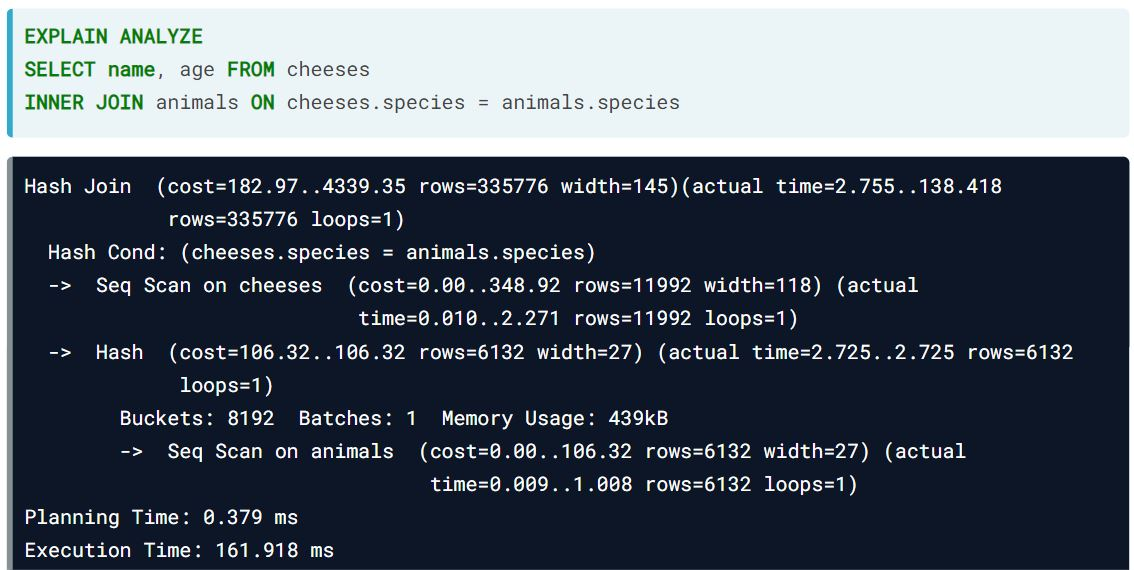

In [16]:
####

### EXERCISEs
#### Exercise 2.1. Aggregating and sorting populations
$\qquad$ You are interested in planning your next vacation. You think it would be fun to visit a country that has changed a lot in recent years. You figure one way to look at change is to look at a change in population. So you focus on countries with big changes in population over the past 25 years.

$\qquad$ You have `annual population` data from the `World Bank` covering each year from 1990 to 2017. 

$\qquad$ Find the countries with the `biggest population changes`. 

$\qquad$ Check your `query plan` to see how the `aggregations impact` the plan.

#### Instructions 
**Step 1.** Find the `population` change by `aggregating population` and `grouping` by the `other columns`.

**SOLUTION.**

                        SELECT region, country,  
                               MAX(population) - MIN(population) as population_change
                        FROM country_pop 
                        GROUP BY country, region

- **`query result.`**

region|country|population_change
:-|:-|:-:
Africa|Algeria|15405775
Africa|Angola|17612752
Africa|Benin|6197196
Africa|Botswana|913749
Africa|Burkina Faso|10382348
Africa|Burundi|5448830
Africa|Cameroon|12338509
Africa|Cape Verde|204505
Africa|Central African Republic|1719300
Africa|Chad|8943135
...|...|...
South America|Argentina|11541302
South America|Bolivia|4195356
South America|Brazil|59936133
South America|Chile|4812594
South America|Colombia|14794050
South America|Ecuador|6406767
South America|Guyana|34550
South America|Paraguay|2597555
South America|Peru|10338827
South America|Suriname|155930

**Step 2.** Check the `query plan` to see how many steps and how long the `query` actually takes.

**SOLUTION.**

                    EXPLAIN ANALYZE
                    SELECT region, country, 
                           MAX(population) - MIN(population) as population_change
                    FROM country_pop 
                    GROUP BY region, country;

- **`query result.`**

|`QUERY PLAN`|
|:-|
|`HashAggregate  (cost=115.00..119.06 rows=325 width=72) (actual time=2.023..2.055 rows=204 loops=1)`|
|$\;$ ` Group Key: region, country`
|$\quad$ `->  Seq Scan on country_pop  (cost=0.00..82.50 rows=3250 width=72) (actual time=0.007..0.490 rows=5703 loops=1)`|
|`Planning Time: 0.062 ms`|
|`Execution Time: 2.092 ms`|

**Step 3.** `Sort` the results to make it easier to find the `countries` with the `biggest population changes`.

**SOLUTION.**

                    SELECT region, country  
                           MAX(population) - MIN(population) as population_change
                    FROM country_pop  
                    GROUP BY  region, country
                    ORDER BY population_change DESC;

- **`query result.`**

region|country|population_change
:-|:-|:-:
Asia|India|469046647
Asia|China|251210000
Africa|Nigeria|95616323
Asia|Pakistan|89337341
Asia|Indonesia|82554558
North America|USA|76096178
South America|Brazil|59936133
Asia|Bangladesh|58481109
Africa|Ethiopia|56870922
Africa|Democratic Republic of Congo|46725407
...|...|...
Europe|Monaco|9256
Europe|Liechtenstein|9175
North America|Bermuda|7041
Australia and Oceania|Palau|6641
Australia and Oceania|Marshall Islands|5829
North America|US Virgin Islands|4679
Australia and Oceania|Nauru|4494
North America|Dominica|4255
North America|Saint Vincent|2392
Australia and Oceania|Tuvalu|2189


**Step 4.** Check if the sorting changed the `query plan` steps and `planning time`.

**SOLUTION.**

                    EXPLAIN ANALYZE
                    SELECT country, region, 
                           MAX(population) - MIN(population) as population_change
                    FROM country_pop  
                    GROUP BY country, region
                    ORDER BY population_change DESC;

- **`query result.`**

|`QUERY PLAN`|
|:-|
|`Sort  (cost=132.62..133.43 rows=325 width=72) (actual time=2.134..2.144 rows=204 loops=1)`|
|$\,$ ` Sort Key: ((max(population) - min(population))) DESC`|
|$\,$ ` Sort Method: quicksort  Memory: 40kB`|
|$\; \;$ ` -> HashAggregate  (cost=115.00..119.06 rows=325 width=72) (actual time=2.030..2.064 rows=204 loops=1)`|
|$\qquad$ `  Group Key: country, region`|
|$\qquad$  `->  Seq Scan on country_pop  (cost=0.00..82.50 rows=3250 width=72) (actual time=0.008..0.492 rows=5703 loops=1)`|
|`Planning Time: 0.068 ms`|
|`Execution Time: 2.183 ms`|

- **Comments.** 

$\qquad \diamond$ Both the `aggregation` and the sorting added `additional steps` to the `query plan`. Planning time decreased with the sort, but `execution time` increased.

$\qquad \diamond$ `India` and `China` were the most populous countries in 2017, and they had the `biggest population changes` in the period since 1990. It looks like you will be packing your bags for an `Asian adventure`.

#### Exercise 2.2. `Joining` in the `query plan`
$\qquad$ `China` and `India` each have over `1 billion` people and together contain `over 30% of the world's people`. You want to see if they are the countries with the `biggest population growth`.

$\qquad$ Since they are both in Asia, you gather population data from the World Bank for `every Asian country between 1990` to `2017`. To simplify your analysis, you decide to compare two years of population data. You compare the `recent (2017) population` to the `1990 population` to find a `population growth metric`.

$\qquad$ Do India and China top the list? Are they the Asian countries with the most growth since the 1990s?

$\qquad$ After writing your `query`, check the `query plan` to see **how the `join impacts the plan`**.

#### Instructions
**Step 1.** Join the two `population` tables on the `country` columns.

**SOLUTION.**

            SELECT old.country, old.region, 
                   old.population_1990, new.population_2017, 
                   100*((new.population_2017 - old.population_1990)/new.population_2017::float) AS population_growth
            FROM pop_1990 old
            INNER JOIN pop_2017 new 
            USING(country)
            ORDER BY population_growth DESC
- **`query result.`**

country|region|population_1990|population_2017|population_growth
:-|:-|:-:|:-:|:-:
Qatar|Asia|476445|2639211|81.9474456570543
United Arab Emirates|Asia|1860174|9400145|80.2112201460722
Bahrain|Asia|495931|1492584|66.7736623198426
Afghanistan|Asia|12249114|35530081|65.5246662679998
Jordan|Asia|3560582|9702353|63.3018712058817
Oman|Asia|1812160|4636262|60.9133392375151
Yemen|Asia|12057039|28250420|57.3208504510729
Lebanon|Asia|2703016|6082357|55.5597279146883
Iraq|Asia|17469005|38274618|54.3587737439992
Saudi Arabia|Asia|16326815|32938213|50.4319952026541
Kuwait|Asia|2099615|4136528|49.2420938526223
Maldives|Asia|223215|436330|48.8426191185571
Israel|Asia|4660000|8712400|46.5130159313163
Singapore|Asia|3047132|5612253|45.7057263811877
Pakistan|Asia|107678614|197015955|45.3452315575152
Cambodia|Asia|8973342|16005373|43.9354396801624
Malaysia|Asia|18038321|31624264|42.9605033653906
Philippines|Asia|61947348|104918090|40.9564661346771
Tajikistan|Asia|5283728|8921343|40.7742982194497
Brunei|Asia|258785|428697|39.6345204188506
Laos|Asia|4258472|6858160|37.9064938700759
Uzbekistan|Asia|20510000|32387200|36.6725125975694
Turkmenistan|Asia|3683966|5758075|36.0208750320202
Nepal|Asia|18749406|29304998|36.0197670035671
Bangladesh|Asia|106188642|164669751|35.5141783143888
India|Asia|870133480|1339180127|35.0249109543424
Bhutan|Asia|537280|807610|33.4728396131796
Turkey|Asia|53921699|80745020|33.2197837092616
Syria|Asia|12446171|18269868|31.8759664820786
Indonesia|Asia|181436821|263991379|31.2716870955093
Iran|Asia|56226185|81162788|30.7241823679098
Kyrgyzstan|Asia|4391200|6201500|29.191324679513
Mongolia|Asia|2184145|3075647|28.9858361508977
Vietnam|Asia|68209605|95540800|28.6068307989885
Azerbaijan|Asia|7159000|9862429|27.4113912505733
Myanmar|Asia|40626250|53370609|23.8789836555922
Hong Kong|Asia|5704500|7391700|22.8256016883802
North Korea|Asia|20293054|25490965|20.3911895842311
Sri Lanka|Asia|17329713|21444000|19.1861919418019
China|Asia|1135185000|1386395000|18.1196556536918
Thailand|Asia|56582821|69037513|18.040470258539
South Korea|Asia|42869283|51466201|16.7040073542634
Kazakhstan|Asia|16348000|18037646|9.36733096990594
Japan|Asia|123537000|126785797|2.56242976490498
Armenia|Asia|3538165|2930450|-20.7379412718183
Georgia|Asia|4802000|3717100|-29.1867315918323


**Step 2.** Use `EXPLAIN` to `view` the `query plan` of the same `query` you just wrote. Which of the following steps are used in the `query plan`?
- `A)` `Sort`
- `B)` `Hash Join`
- `C)` `Seq Scan`
- `D)` `Sort Key`
- `E)` `A`, `B`, and `C`
- `F)` All of the above.

**SOLUTION.** To chose the correct answer, look at the following commands and its `result` (`query result.`) below.

- **`query result.`**

|`QUERY PLAN`|
|:-|
|`Sort  (cost=395.71..403.91 rows=3280 width=88)`|
|`  Sort Key: (('100'::double precision * (((new.population_2017 - old.population_1990))::double precision / (new.population_2017)::double precision))) DESC `|
| `  ->  Hash Join  (cost=28.23..204.16 rows=3280 width=88)`|
|  `      Hash Cond: (old.country = new.country)` |
|   `     ->  Seq Scan on pop_1990 old  (cost=0.00..18.10 rows=810 width=72)`|
|    `    ->  Hash  (cost=18.10..18.10 rows=810 width=40)`|
|    `          ->  Seq Scan on pop_2017 new  (cost=0.00..18.10 rows=810 width=40)`|

- **Comments.**

$\qquad \diamond$ The `Sort Key` describes the `Sort step` and noting that **`rows` without `arrows` that are not the `top row describe steps`** hence `Sort Key` is the wrong options! Therefore, the options *`D`* is *Wrong* and *`F`* contains *`D` is also Incorrect*.

$\qquad \diamond$ In the `query plan`, there are `Sort, Hash Join` and `Seq Scan`. If we only pick one of them (`A` or `B` or `C`), this is `True`, **but this is not the only step listed**.

$\qquad \diamond$ The **`correct answer`** is **`E`**.

$\qquad \diamond$ The top row and rows with arrows are the plan steps.

## 3. Query structure and query execution
### `Sub-queries` and `joins`

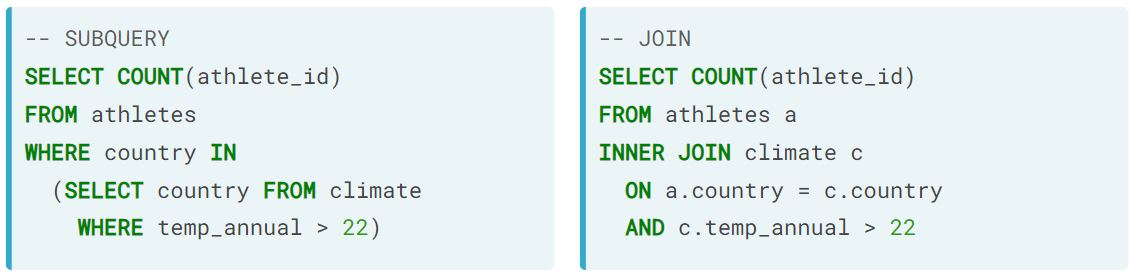

In [17]:
#### Example

#### `query plan`

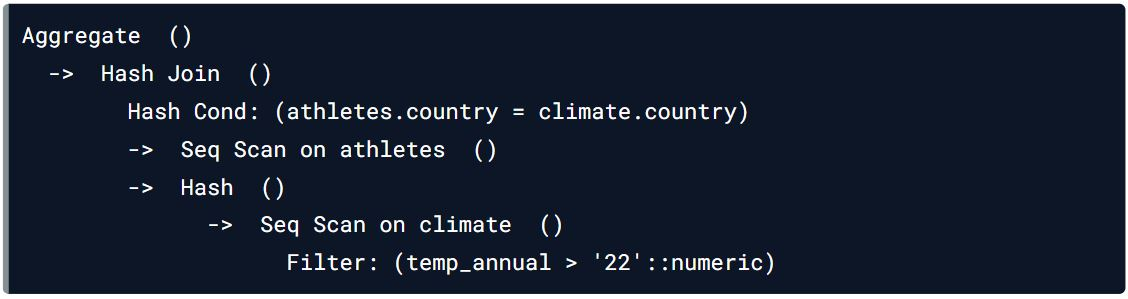

In [18]:
####

#### `CTEs (common table expression)` and `temporary table`

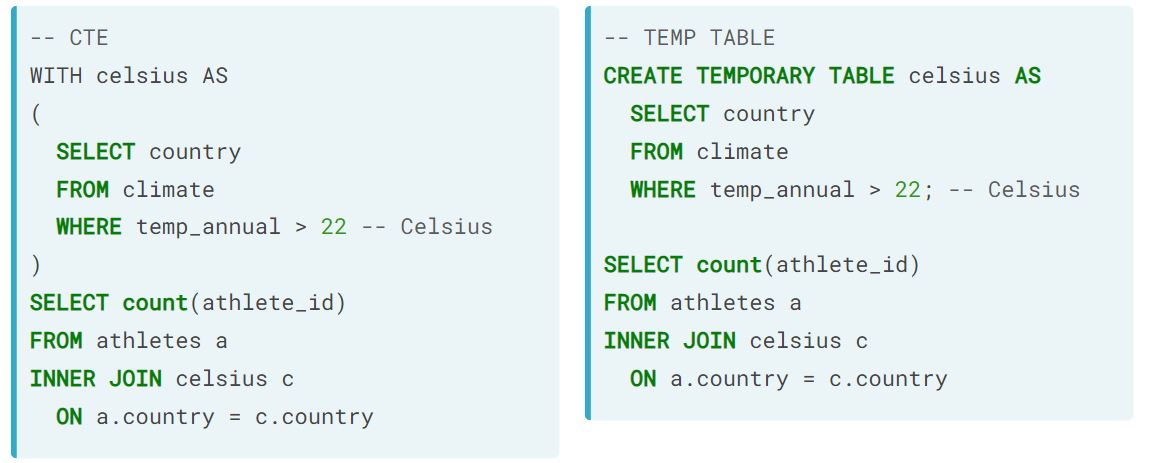

In [19]:
####

#### `query plan`

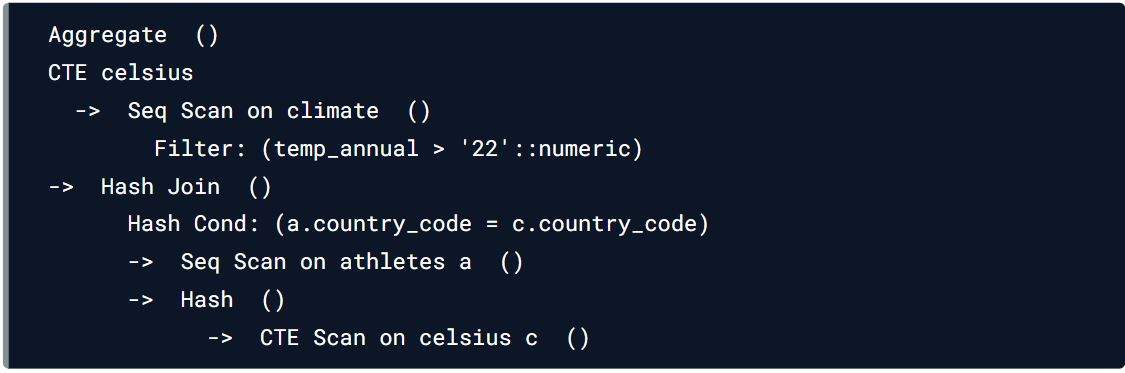

In [20]:
#### 

### `Limiting the data`.

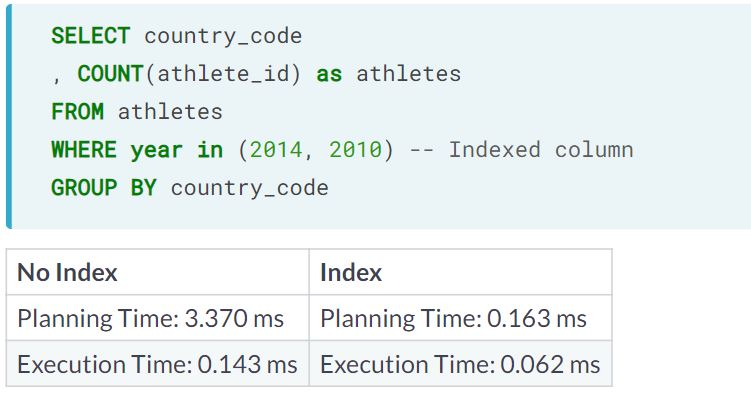

In [21]:
#### 

### `Aggregation` - `different granularities`.

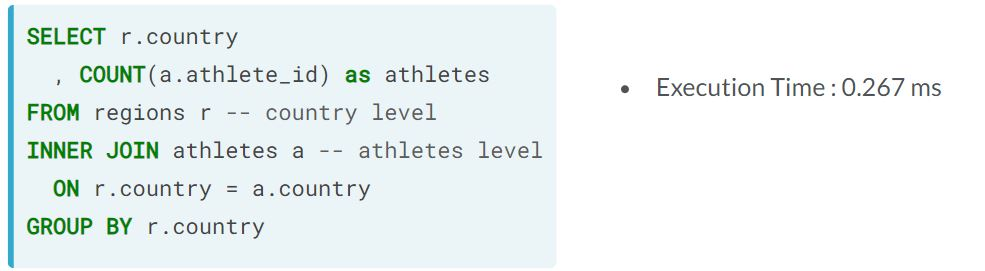

In [22]:
#### 

### `Aggregation` - changing the `granularities`.

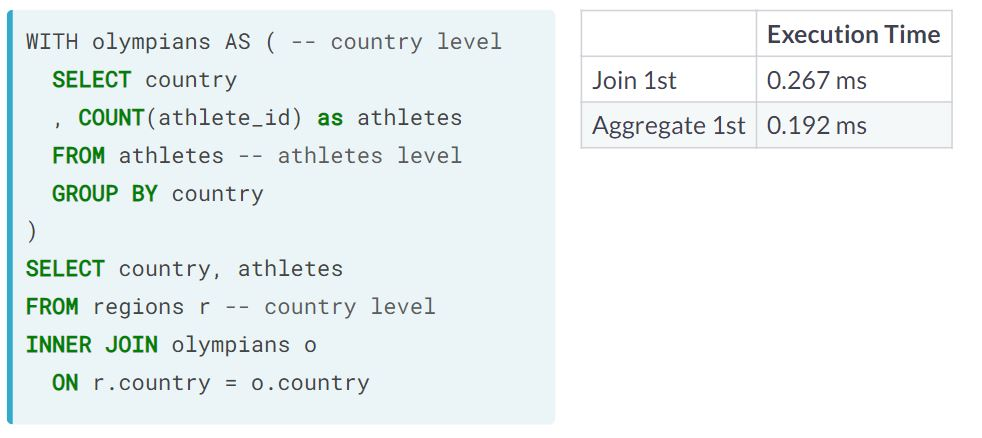

In [23]:
#### 

### EXERCISEs.
#### Exercise 3.1. Subqueries vs. CTEs
$\qquad$ You have learned different ways of writing `queries` and how these `choices impact performance`. This exercise will again look at country demographics for the African countries with athletes competing in the Olympics. You will focus on the Summer Olympics.

$\qquad$ Using `pre-written queries`, you will restructure the queries and assess the impact of the changes. You will start by seeing the difference in query plans when using subqueries compared to `common table expressions (CTEs)`.

Run the `execution plan` for each step.

#### Instructions
**Step 1.** Run the `execution plan`. Notice the order of the `demographics` filtering step (`GDP` and `year`) in the `query plan`.

**SOLUTION.**

                    -- Subquery
                    EXPLAIN ANALYZE
                    SELECT city, sex, 
                           COUNT(DISTINCT athlete_id) as no_athletes, 
                           AVG(age) as avg_age
                    FROM athletes_summ
                    WHERE country_code IN (SELECT olympic_cc FROM demographics WHERE gdp > 10000 and year = 2016)
                    AND year = 2016
                    GROUP BY city, sex;

- **`query result.`**

|`QUERY PLAN`|
|:-|
|`GroupAggregate  (cost=585.96..600.18 rows=68 width=50) (actual time=3.071..3.183 rows=2 loops=1)`|
|$\,$ `  Group Key: athletes_summ.city, athletes_summ.sex`|
|$\,$ `-> Sort  (cost=585.96..588.64 rows=1069 width=16) (actual time=3.001..3.024 rows=491 loops=1)`|
|$\quad$ ` Sort Key: athletes_summ.city, athletes_summ.sex`|
|$\quad$ ` Sort Method: quicksort  Memory: 63kB`
|$\quad$  `-> Hash Join  (cost=138.58..532.18 rows=1069 width=16) (actual time=0.847..2.795 rows=491 loops=1)`|
|$\qquad$ ` Hash Cond: (athletes_summ.country_code = demographics.olympic_cc)`|
|$\qquad \;$ `-> Seq Scan on athletes_summ  (cost=0.00..378.90 rows=1069 width=20) (actual time=0.008..1.797 rows=1069 loops=1)`|
|$\qquad \quad \;$  `   Filter: (year = 2016)`|
|$\qquad \quad \;$  `   Rows Removed by Filter: 10923`|
|$\qquad \quad$  `-> Hash  (cost=137.79..137.79 rows=63 width=4) (actual time=0.823..0.823 rows=107 loops=1)`|
|$\qquad \qquad$  ` Buckets: 1024  Batches: 1  Memory Usage: 12kB`|
|$\qquad \qquad \quad$  ` -> HashAggregate  (cost=137.16..137.79 rows=63 width=4) (actual time=0.798..0.809 rows=107 loops=1)`|
|$\qquad \qquad \qquad$  ` Group Key: demographics.olympic_cc`|
|$\qquad \qquad \qquad$  `-> Seq Scan on demographics  (cost=0.00..136.98 rows=74 width=4) (actual time=0.013..0.778 rows=107 loops=1)`|
|$\qquad \qquad \qquad$  `     Filter: ((gdp > '10000'::numeric) AND (year = 2016))`|
|$\qquad \qquad \qquad$  `     Rows Removed by Filter: 6025`|
|`Planning Time: 0.424 ms`|
|`Execution Time: 3.235 ms`|

**Step 2.** Restructure the `demographics` `subquery` into a `CTE` and run the `execution plan`.

**SOLUTION.**

                    -- Note the initial step in the query plan

                    -- Common Table Expression (CTE)
                    EXPLAIN ANALYZE
                    WITH gdp AS -- From the demographics table
                    (
                      SELECT olympic_cc FROM demographics WHERE gdp > 10000 and year = 2016
                    )
                    SELECT a.city, a.sex, 
                           COUNT(DISTINCT a.athlete_id) as no_athletes, 
                           AVG(a.age) AS avg_age
                    FROM athletes_summ a
                    INNER JOIN gdp
                        ON a.country_code = gdp.olympic_cc
                    WHERE a.year = 2016
                    GROUP BY a.city, a.sex;

- **`query result.`**

|`QUERY PLAN`|
|:-|
|`GroupAggregate  (cost=586.77..600.98 rows=68 width=50) (actual time=3.085..3.200 rows=2 loops=1)`|
|$\,$ `  Group Key: a.city, a.sex`|
|$\;$ `  CTE gdp`|
|$\quad$ `-> Seq Scan on demographics  (cost=0.00..136.98 rows=74 width=4) (actual time=0.014..0.805 rows=107 loops=1)`|
|$\quad$ ` Filter: ((gdp > '10000'::numeric) AND (year = 2016))`|
|$\quad$ ` Rows Removed by Filter: 6025`|
|$\,$  `-> Sort  (cost=449.79..452.46 rows=1069 width=16) (actual time=3.019..3.045 rows=491 loops=1)`|
|$\;\,$ `  Sort Key: a.city, a.sex`|
|$\;\,$ `  Sort Method: quicksort  Memory: 63kB`|
|$\quad$ `-> Hash Join  (cost=2.41..396.00 rows=1069 width=16) (actual time=0.864..2.818 rows=491 loops=1)`|
|$\quad$ `   Hash Cond: (a.country_code = gdp.olympic_cc)`|
|$\qquad$ `-> Seq Scan on athletes_summ a  (cost=0.00..378.90 rows=1069 width=20) (actual time=0.009..1.795 rows=1069 loops=1)`|
|$\qquad \,$ ` Filter: (year = 2016)`|
|$\qquad \,$ ` Rows Removed by Filter: 10923`|
|$\qquad \,$ ` ->  Hash  (cost=1.48..1.48 rows=74 width=16) (actual time=0.844..0.845 rows=107 loops=1)`|
|$\qquad \qquad$ `  Buckets: 1024  Batches: 1  Memory Usage: 12kB`|
|$\qquad \qquad$ ` -> CTE Scan on gdp  (cost=0.00..1.48 rows=74 width=16) (actual time=0.015..0.830 rows=107 loops=1)`|
|`Planning Time: 0.172 ms`|
|`Execution Time: 3.251 ms`|

- **Comments.** Ideally, the query plan limits the number of records as soon as possible, but putting a filter in the `CTE` restricts the `query planner`'s ability to perform this filter condition outside of the `CTE`.

#### Exercise 3.2. Why the difference?
$\qquad$ The execution plan differs when using a `subquery` versus a `common table expression (CTE) structure`.

$\qquad$ The following statements describe `execution rules` that are only true for `CTEs`. Choose the statement that does **NOT** describe a difference in the `execution` between a s`ubquery` and `CTE`.

- A. The written `order of joins` in a `CTEs` matches the `order of execution` seen in the `query planner`.
- B. `CTEs` are only executed once per `query`, even if they are referenced more than one time in the `parent query`.
- C. `CTEs` create a `temporary table`.
- D. If a `column` with an `index` is `referenced` in a `CTE`, the `index` is also available `outside` of that `CTE`.

**Answers & comments.**

- **A. Correct!!!** The `query planner` has flexibility in how it executes the `query` so that the written `order of joins` in both `subqueries` and `CTEs` rarely matches the `execution plan`.
- *B. Wrong!!* `Subqueries` may be called `multiple times`, whereas `CTEs` are only called `once`.
- *C. Incorrect!!* Only `CTEs`, and not `subqueries`, are `materialized` into a `temporary table`.
- *D. Wrong!!* Because `CTEs` are `materialized`, the `temporary table` is `unique`. It *does not inherit* the `indexes` of `its reference (original) tables(s)`.

#### Exercise 3.3. Filtering impacts
$\qquad$ You will revisit filtering while examining the African countries with `athletes` competing in the `Summer Olympics`. You will look at the average age by gender for the `Rio de Janeiro` and `Beijing games`.

$\qquad$ Along the way, you will compare the query plans using `numeric filters`, `text filters`, and `indexed filters`.

#### Instructions .
**Step 1.** Use `age` to find which Olympics, on average, had the `youngest female athletes`.

**SOLUTION.**

                    SELECT city, sex, 
                        COUNT(DISTINCT athlete_id), AVG(age) AS avg_age
                    FROM athletes_summ
                    WHERE city IN ('Rio de Janeiro','Beijing')
                    GROUP BY city, sex;

- **`query result`.**

city|sex|count|avg_age
:-|:-:|:-:|:-:
Beijing|F|319|24.0630136986301370
Beijing|M|526|25.1039861351819757
Rio de Janeiro|F|379|24.9097560975609756
Rio de Janeiro|M|611|25.4537177541729894

**Step 2.** Check the `query's execution time`.

**SOLUTION.**

                    -- Read the query plan with the text city filter
                    EXPLAIN ANALYZE
                    SELECT city, sex, COUNT(DISTINCT athlete_id), AVG(age) AS avg_age
                    FROM athletes_summ
                    WHERE city IN ('Rio de Janeiro','Beijing')
                    GROUP BY city, sex;

- **`query result`.**

|`QUERY PLAN`|
|:-|
|`GroupAggregate  (cost=489.24..515.23 rows=68 width=50) (actual time=3.386..3.911 rows=4 loops=1)`|
|$\;\,$ ` Group Key: city, sex`|
|$\;$ ` ->  Sort  (cost=489.24..494.27 rows=2011 width=16) (actual time=3.254..3.352 rows=2011 loops=1)`|
|$\qquad$ ` Sort Key: city, sex`|
|$\,\qquad$ `   Sort Method: quicksort  Memory: 206kB`|
|$\qquad$ ` -> Seq Scan on athletes_summ  (cost=0.00..378.90 rows=2011 width=16) (actual time=0.010..2.520 rows=2011 loops=1)`|
|$\qquad \qquad$ ` Filter: (city = ANY ('{"Rio de Janeiro",Beijing}'::text[]))`|
|$\qquad \qquad$ ` Rows Removed by Filter: 9981`|
|`Planning Time: 0.170 ms`|
|`Execution Time: 3.966 ms`| 


**Step 3.** Now `limit` the results using the `numeric year filter` (2008, 2016) and run the new `execution plan`.

**SOLUTION.**

                -- Find the execution time with a numeric year filter
                EXPLAIN ANALYZE
                SELECT city, sex, COUNT(DISTINCT athlete_id), AVG(age) AS avg_age
                FROM athletes_summ
                WHERE year IN (2016, 2008) -- Filter by year
                GROUP BY city, sex;

- **`query result`.**

|`QUERY PLAN`|
|:-|
|`GroupAggregate  (cost=489.24..515.23 rows=68 width=50) (actual time=3.058..3.583 rows=4 loops=1)`|
|$\;\,$ ` Group Key: city, sex`|
|$\;$ ` ->  Sort  (cost=489.24..494.27 rows=2011 width=16) (actual time=2.927..3.025 rows=2011 loops=1)`|
|$\qquad$ ` Sort Key: city, sex`|
|$\,\qquad$ `   Sort Method: quicksort  Memory: 206kB`|
|$\qquad$ ` -> Seq Scan on athletes_summ  (cost=0.00..378.90 rows=2011 width=16) (actual time=0.010..2.520 rows=2011 loops=1)`|
|$\qquad \qquad$ ` Filter: (year = ANY ('{2016,2008}'::integer[]))`|
|$\qquad \qquad$ ` Rows Removed by Filter: 9981`|
|`Planning Time: 0.088 ms`|
|`Execution Time: 3.630 ms`| 

- **Comments.** You can see that even the `small change` from a `text` to a `numeric` column **saved time**. While a small difference, the `Beijing Olympics` had slightly younger female athletes than the `Rio de Janeiro Olympics`.